# Ataki Zwodnicze z użyciem TextAttack

Ten notatnik demonstruje, jak przeprowadzać ataki adwersarialne na model Hugging Face przy użyciu biblioteki `textattack`.
Użyjemy modelu **DistilBERT** dostrojonego do zbioru **SST-2** (lub Rotten Tomatoes) i zastosujemy dwie metody ataku:
1. **TextFooler**
2. **PWWS** (Probability Weighted Word Saliency)


In [1]:
import textattack
import transformers
import torch
import nltk
from textattack.models.wrappers import HuggingFaceModelWrapper
from textattack.datasets import HuggingFaceDataset
from textattack.attack_recipes import TextFoolerJin2019, PWWSRen2019
from textattack import Attacker
from textattack import AttackArgs

# Download necessary NLTK data for TextFooler
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('universal_tagset')

C:\Users\Damian\Desktop\Inżynierka here\Adversarial_Attacks\.venv1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Damian\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Damian\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [14]:
# 1. Wczytaj model i tokenizator
# Wykorzystujemy standardowy model DistilBERT dostrojony na zbiorze SST-2 do analizy sentymentu
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

# Dostosuj model do interfejsu TextAttack (wrapper)
model_wrapper = HuggingFaceModelWrapper(model, tokenizer)

In [16]:
# 2. Wczytaj zbiór danych
# Wykorzystujemy zbiór Rotten Tomatoes do analizy sentymentu (klasyfikacja binarna)
# split='test', aby przeprowadzić atak na przykładach, których model wcześniej nie widział (dane nieznane)
# WAŻNE: ustawienie shuffle=False jest wymagane przy korzystaniu z checkpoint_interval w AttackArgs
dataset = HuggingFaceDataset("rotten_tomatoes", split="test", shuffle=False)
print("Dataset Załadowany poprawnie.")

textattack: Loading datasets dataset rotten_tomatoes, split test.


Dataset Załadowany poprawnie.


## Attack 1: TextFooler


### Jak to działa?
**TextFooler** to metoda, która stara się oszukać model poprzez podmianę słów na ich synonimy.
1.  **Ważność słów:** Najpierw sprawdza, które słowa są najważniejsze dla decyzji modelu.
2.  **Szukanie synonimów:** Dla najważniejszych słów szuka zamienników, które mają podobne znaczenie.
3.  **Sprawdzanie sensu:** Używa dodatkowych narzędzi (Universal Sentence Encoder), aby upewnić się, że nowe zdanie nadal ma sens i jest gramatycznie poprawne.
4.  **Podmiana:** Podmienia słowa tak długo, aż model zmieni zdanie (np. z "Pozytywny" na "Negatywny").

In [17]:
# Zainicjalizuj przepis(recipe) ataku TextFooler
attack_textfooler = TextFoolerJin2019.build(model_wrapper)

# Określ parametry ataku
attack_args_textfooler = AttackArgs(
    num_examples=5, 
    log_to_csv="textfooler_results.csv",
    checkpoint_interval=5,
    checkpoint_dir="checkpoints_textfooler",
    disable_stdout=False  # Print progress to stdout
)

# Zainicjalizuj mechanizm wykonujący atak
attacker_textfooler = Attacker(attack_textfooler, dataset, attack_args_textfooler)

# Uruchom Atak
print("Running TextFooler Attack...")
results_textfooler = attacker_textfooler.attack_dataset()
print("TextFooler Attack Complete.")

textattack: Unknown if model of class <class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path textfooler_results.csv


Running TextFooler Attack...
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['pr

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 1/5 [00:44<02:56, 44.06s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Positive (100%)]] --> [[Negative (80%)]]

[[lovingly]] photographed in the [[manner]] of a [[golden]] book sprung to [[life]] , stuart little 2 [[manages]] [[sweetness]] largely without stickiness .

[[elaborately]] photographed in the [[routing]] of a [[dorado]] book sprung to [[subsistence]] , stuart little 2 [[runs]] [[luv]] largely without stickiness .




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  40%|████      | 2/5 [00:48<01:12, 24.18s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (100%)]] --> [[Negative (100%)]]

consistently [[clever]] and [[suspenseful]] .

consistently [[shrewd]] and [[nightmarish]] .




[Succeeded / Failed / Skipped / Total] 2 / 0 / 1 / 3:  60%|██████    | 3/5 [00:48<00:32, 16.19s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Negative (99%)]] --> [[[SKIPPED]]]

it's like a " big chill " reunion of the baader-meinhof gang , only these guys are more harmless pranksters than political activists .




[Succeeded / Failed / Skipped / Total] 3 / 0 / 1 / 4:  80%|████████  | 4/5 [01:27<00:21, 21.86s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (100%)]] --> [[Negative (57%)]]

the story gives [[ample]] [[opportunity]] for large-scale [[action]] and [[suspense]] , which director shekhar kapur supplies with [[tremendous]] [[skill]] .

the story gives [[widespread]] [[hazard]] for large-scale [[measurements]] and [[sufferance]] , which director shekhar kapur supplies with [[stupendous]] [[skills]] .




[Succeeded / Failed / Skipped / Total] 4 / 0 / 1 / 5: 100%|██████████| 5/5 [01:37<00:00, 19.41s/it]textattack: Saving checkpoint under "checkpoints_textfooler\1763852994575.ta.chkpt" at 2025-11-23 00:09:54 after 5 attacks.


--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (100%)]] --> [[Negative (70%)]]

red dragon " never [[cuts]] corners .

red dragon " never [[cortes]] corners .







[Succeeded / Failed / Skipped / Total] 4 / 0 / 1 / 5: 100%|██████████| 5/5 [01:37<00:00, 19.41s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 4      |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 80.0%  |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 33.33% |
| Average num. words per input: | 13.4   |
| Avg num queries:              | 123.5  |
+-------------------------------+--------+
TextFooler Attack Complete.


In [18]:
# Wyświetl wyniki
for result in results_textfooler:
    print(result.__str__(color_method='ansi'))

Positive (100%) --> Negative (80%)

lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .

elaborately photographed in the routing of a dorado book sprung to subsistence , stuart little 2 runs luv largely without stickiness .
Positive (100%) --> Negative (100%)

consistently clever and suspenseful .

consistently shrewd and nightmarish .
Negative (99%) --> [38:5:240m[SKIPPED]

it's like a " big chill " reunion of the baader-meinhof gang , only these guys are more harmless pranksters than political activists .
Positive (100%) --> Negative (57%)

the story gives ample opportunity for large-scale action and suspense , which director shekhar kapur supplies with tremendous skill .

the story gives widespread hazard for large-scale measurements and sufferance , which director shekhar kapur supplies with stupendous skills .
Positive (100%) --> Negative (70%)

red dragon " never cuts corners .

red dragon " never c

## Attack 2: PWWS (Probability Weighted Word Saliency)


### Jak to działa?
**PWWS** to bardziej zaawansowana metoda niż prosta podmiana słów. Bierze pod uwagę dwie rzeczy:
1.  **Wpływ na wynik:** Jak bardzo zmiana danego słowa wpłynie na decyzję modelu.
2.  **Wpływ na zdanie:** Jak bardzo zmiana słowa wpłynie na samo zdanie (czy nadal będzie brzmiało naturalnie).

Algorytm wylicza specjalną wagę dla każdego słowa i podmienia je w kolejności, która daje największą szansę na oszukanie modelu przy najmniejszej zmianie znaczenia.

In [19]:
# Initialize PWWS attack recipe
attack_pwws = PWWSRen2019.build(model_wrapper)

# Określ parametry ataku
attack_args_pwws = AttackArgs(
    num_examples=5, 
    log_to_csv="pwws_results.csv",
    checkpoint_interval=5,
    checkpoint_dir="checkpoints_pwws",
    disable_stdout=False
)

# Zainicjalizuj mechanizm wykonujący atak
attacker_pwws = Attacker(attack_pwws, dataset, attack_args_pwws)

# Uruchom Atak
print("Running PWWS Attack...")
results_pwws = attacker_pwws.attack_dataset()
print("PWWS Attack Complete.")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Damian\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
textattack: Unknown if model of class <class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path pwws_results.csv


Running PWWS Attack...
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  20%|██        | 1/5 [00:35<02:22, 35.60s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Positive (100%)]] --> [[[FAILED]]]

lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  40%|████      | 2/5 [00:39<00:58, 19.52s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (100%)]] --> [[Negative (100%)]]

consistently [[clever]] and [[suspenseful]] .

consistently [[cagy]] and [[cliff-hanging]] .




[Succeeded / Failed / Skipped / Total] 1 / 1 / 1 / 3:  60%|██████    | 3/5 [00:39<00:26, 13.10s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Negative (99%)]] --> [[[SKIPPED]]]

it's like a " big chill " reunion of the baader-meinhof gang , only these guys are more harmless pranksters than political activists .




[Succeeded / Failed / Skipped / Total] 2 / 1 / 1 / 4:  80%|████████  | 4/5 [01:08<00:17, 17.01s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (100%)]] --> [[Negative (83%)]]

the story [[gives]] [[ample]] opportunity for large-scale action and suspense , which director shekhar kapur [[supplies]] with [[tremendous]] skill .

the story [[dedicate]] [[sizable]] opportunity for large-scale action and suspense , which director shekhar kapur [[supplying]] with [[awful]] skill .




[Succeeded / Failed / Skipped / Total] 3 / 1 / 1 / 5: 100%|██████████| 5/5 [01:22<00:00, 16.51s/it]textattack: Saving checkpoint under "checkpoints_pwws\1763853109461.ta.chkpt" at 2025-11-23 00:11:49 after 5 attacks.


--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (100%)]] --> [[Negative (100%)]]

red dragon " [[never]] cuts corners .

red dragon " [[ne'er]] cuts corners .







[Succeeded / Failed / Skipped / Total] 3 / 1 / 1 / 5: 100%|██████████| 5/5 [01:22<00:00, 16.51s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 3      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 80.0%  |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 75.0%  |
| Average perturbed word %:     | 30.74% |
| Average num. words per input: | 13.4   |
| Avg num queries:              | 120.75 |
+-------------------------------+--------+
PWWS Attack Complete.


In [20]:
# Wyświetl wyniki
for result in results_pwws:
    print(result.__str__(color_method='ansi'))

Positive (100%) --> [FAILED]

lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .
Positive (100%) --> Negative (100%)

consistently clever and suspenseful .

consistently cagy and cliff-hanging .
Negative (99%) --> [38:5:240m[SKIPPED]

it's like a " big chill " reunion of the baader-meinhof gang , only these guys are more harmless pranksters than political activists .
Positive (100%) --> Negative (83%)

the story gives ample opportunity for large-scale action and suspense , which director shekhar kapur supplies with tremendous skill .

the story dedicate sizable opportunity for large-scale action and suspense , which director shekhar kapur supplying with awful skill .
Positive (100%) --> Negative (100%)

red dragon " never cuts corners .

red dragon " ne'er cuts corners .


## Interpretacja Wyników

W tabelach wyników (Attack Results) widzisz:
- **Number of successful attacks:** Ile razy udało się oszukać model.
- **Number of failed attacks:** Ile razy model nie dał się oszukać.
- **Skipped attacks:** Ile przykładów pominięto (zazwyczaj dlatego, że model pomylił się już na oryginalnym tekście, więc nie było czego atakować).
- **Original accuracy:** Jak dobry był model przed atakiem (np. 80%).
- **Accuracy under attack:** Jak dobry jest model po ataku (np. 0% lub 20%). Im mniej, tym skuteczniejszy był atak.
- **Attack success rate:** Skuteczność ataku (np. 100% oznacza, że każdy próbowany atak się udał).

**Kolory w wynikach:**
- **Zielony:** Słowa, które model oceniał jako dowód na swoją pierwotną decyzję.
- **Czerwony:** Słowa podmienione przez atak, które zmyliły model.

### TABELA PORÓWNAWCZA METOD ATAKU ###


,Metryka,TextFooler,PWWS
0,Udane ataki (Succeeded),4,3
1,Nieudane ataki (Failed),0,1
2,Pominięte (Skipped),1,1
3,Oryginalna dokładność (Original Accuracy),80.0%,80.0%
4,Dokładność pod atakiem (Accuracy under Attack),0.0%,20.0%
5,Skuteczność ataku (Success Rate),100.0%,75.0%
6,Śr. % zmienionych słów,33.33%,30.74%
7,Śr. liczba zapytań (Queries),123.5,120.75


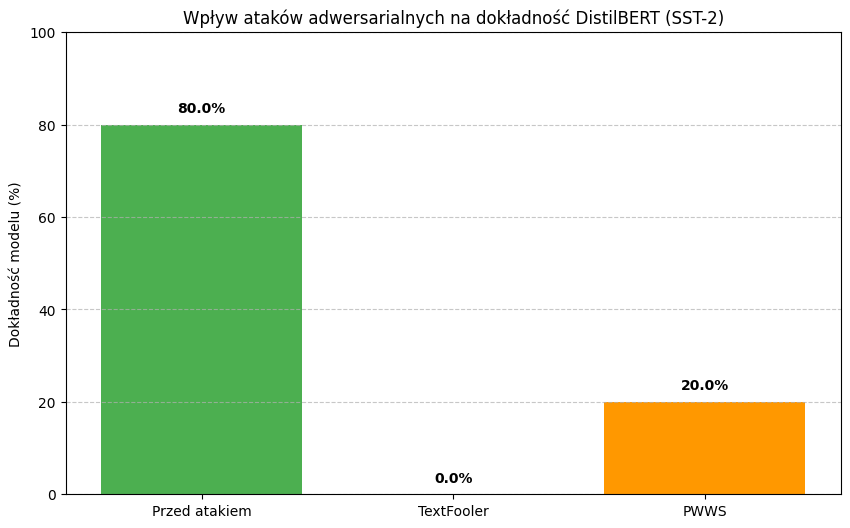


### ANALIZA I WNIOSKI ###

1. SKUTECZNOŚĆ (Ile/Jaki wpływ):
   - TextFooler okazał się w pełni skuteczny na testowanej próbie, redukując dokładność modelu z 80% do 0%.
   - PWWS był nieco mniej skuteczny (Success Rate 75%), a model zachował 20% dokładności pod wpływem tego ataku.

2. METODYKA (Jak):
   - TextFooler opiera się na prostszej zamianie synonimów z kontrolą sensu przez Universal Sentence Encoder.
     Wymagał on średnio więcej modyfikacji w tekście (33.33% słów).
   - PWWS (Probability Weighted Word Saliency) jest metodą bardziej 'chirurgiczną' – analizuje wpływ każdego słowa
     na prawdopodobieństwo klasyfikacji. W teście zmienił on mniejszy procent słów (30.74%) i wykonał mniej zapytań
     do modelu (120.75 vs 123.5), co czyni go atakiem bardziej dyskretnym, choć w tym małym zbiorze mniej skutecznym.

3. PODSUMOWANIE:
   - Model DistilBERT wykazuje dużą podatność na oba rodzaje ataków. Wystarczy zmiana ok. 1/3 słów w recenzji,
     aby całkowicie zmienić interpretację 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Przygotowanie danych syntetycznych na podstawie wyników z notatnika
data = {
    "Metryka": [
        "Udane ataki (Succeeded)",
        "Nieudane ataki (Failed)",
        "Pominięte (Skipped)",
        "Oryginalna dokładność (Original Accuracy)",
        "Dokładność pod atakiem (Accuracy under Attack)",
        "Skuteczność ataku (Success Rate)",
        "Śr. % zmienionych słów",
        "Śr. liczba zapytań (Queries)"
    ],
    "TextFooler": [4, 0, 1, "80.0%", "0.0%", "100.0%", "33.33%", 123.5],
    "PWWS": [3, 1, 1, "80.0%", "20.0%", "75.0%", "30.74%", 120.75]
}

df_results = pd.DataFrame(data)

# Wyświetlenie tabeli
print("### TABELA PORÓWNAWCZA METOD ATAKU ###")
display(df_results)

# 2. Wizualizacja wpływu ataku na dokładność modelu
methods = ['Przed atakiem', 'TextFooler', 'PWWS']
accuracies = [80.0, 0.0, 20.0]

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, accuracies, color=['#4CAF50', '#f44336', '#ff9800'])
plt.ylabel('Dokładność modelu (%)')
plt.title('Wpływ ataków adwersarialnych na dokładność DistilBERT (SST-2)')
plt.ylim(0, 100)

# Dodanie etykiet nad słupkami
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f'{yval}%', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Analiza i wnioski
print("\n### ANALIZA I WNIOSKI ###")
analysis = """
1. SKUTECZNOŚĆ (Ile/Jaki wpływ):
   - TextFooler okazał się w pełni skuteczny na testowanej próbie, redukując dokładność modelu z 80% do 0%.
   - PWWS był nieco mniej skuteczny (Success Rate 75%), a model zachował 20% dokładności pod wpływem tego ataku.

2. METODYKA (Jak):
   - TextFooler opiera się na prostszej zamianie synonimów z kontrolą sensu przez Universal Sentence Encoder.
     Wymagał on średnio więcej modyfikacji w tekście (33.33% słów).
   - PWWS (Probability Weighted Word Saliency) jest metodą bardziej 'chirurgiczną' – analizuje wpływ każdego słowa
     na prawdopodobieństwo klasyfikacji. W teście zmienił on mniejszy procent słów (30.74%) i wykonał mniej zapytań
     do modelu (120.75 vs 123.5), co czyni go atakiem bardziej dyskretnym, choć w tym małym zbiorze mniej skutecznym.

3. PODSUMOWANIE:
   - Model DistilBERT wykazuje dużą podatność na oba rodzaje ataków. Wystarczy zmiana ok. 1/3 słów w recenzji,
     aby całkowicie zmienić interpretację sentymentu przez model, mimo że dla człowieka sens zdania pozostaje zbliżony.
"""
print(analysis)